In [21]:
from stage1 import *

In [22]:
nframes,natoms,nmols=(0,0,0)

In [23]:
from stage2 import * 

In [24]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [25]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [26]:
cf=condenseframe(testframe)

In [27]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [28]:
cf

array([[ 9.89732184e+02, -1.19746289e+02, -1.97409429e+02,
         2.28225017e+00,  9.52250063e-01,  1.95350003e+00],
       [ 9.89768499e+02, -1.19735860e+02, -1.97410766e+02,
         1.36549997e+00,  1.45650005e+00,  2.59900022e+00],
       [ 9.89681805e+02, -1.19738573e+02, -1.97401416e+02,
         8.33750010e-01,  1.77175009e+00,  7.37500072e-01],
       ...,
       [ 9.89936113e+02, -1.19777279e+02, -1.97450172e+02,
         2.56474996e+00,  1.57500005e+00,  2.47574997e+00],
       [ 9.89917252e+02, -1.19778816e+02, -1.97441199e+02,
         1.61825013e+00,  1.92200017e+00,  2.49900007e+00],
       [ 9.89954919e+02, -1.19774158e+02, -1.97441629e+02,
         7.91500092e-01,  2.24175000e+00,  2.16525006e+00]])

In [29]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:02<00:00, 22.14it/s]

30192


In [30]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [31]:
g = get_graph(cf,1,n_neigh,"cry")

In [32]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [33]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 20
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [34]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:01<00:00, 22971.20it/s]


In [35]:
graphs = graphs_device
total_graphs = len(graphs)


In [36]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [37]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [38]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [39]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [40]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 135494.3040
	Test: 	MSE Loss: 103124.9574
Epoch: 002
	Train:	MSE Loss: 55775.1845
	Test: 	MSE Loss: 37647.4063
Epoch: 003
	Train:	MSE Loss: 29572.9749
	Test: 	MSE Loss: 21686.0897
Epoch: 004
	Train:	MSE Loss: 19143.8305
	Test: 	MSE Loss: 14976.8194
Epoch: 005
	Train:	MSE Loss: 13113.8616
	Test: 	MSE Loss: 10705.4303
Epoch: 006
	Train:	MSE Loss: 9386.1766
	Test: 	MSE Loss: 8189.1069
Epoch: 007
	Train:	MSE Loss: 7509.4391
	Test: 	MSE Loss: 7045.6693
Epoch: 008
	Train:	MSE Loss: 6717.9310
	Test: 	MSE Loss: 6446.1848
Epoch: 009
	Train:	MSE Loss: 6164.0272
	Test: 	MSE Loss: 5878.3592
Epoch: 010
	Train:	MSE Loss: 5486.3260
	Test: 	MSE Loss: 5021.5363
Epoch: 011
	Train:	MSE Loss: 4281.4896
	Test: 	MSE Loss: 3356.7400
Epoch: 012
	Train:	MSE Loss: 2159.4214
	Test: 	MSE Loss: 1087.9149
Epoch: 013
	Train:	MSE Loss: 578.7636
	Test: 	MSE Loss: 287.1714
Epoch: 014
	Train:	MSE Loss: 177.2971
	Test: 	MSE Loss: 104.1994
Epoch: 015
	Train:	MSE Loss: 70.3707
	Test: 	MSE Loss:

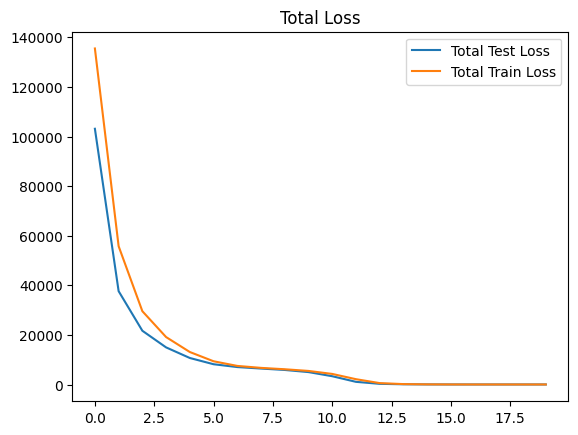

In [41]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

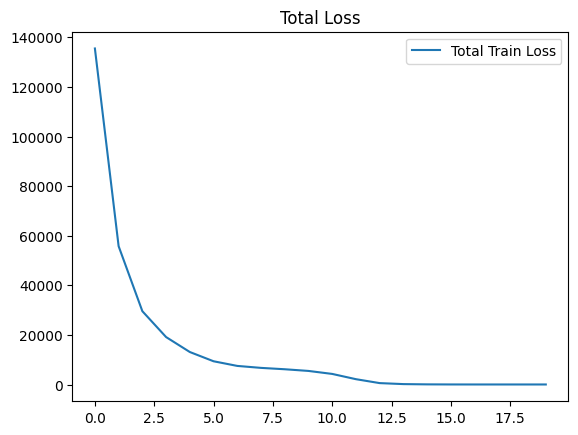

In [42]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

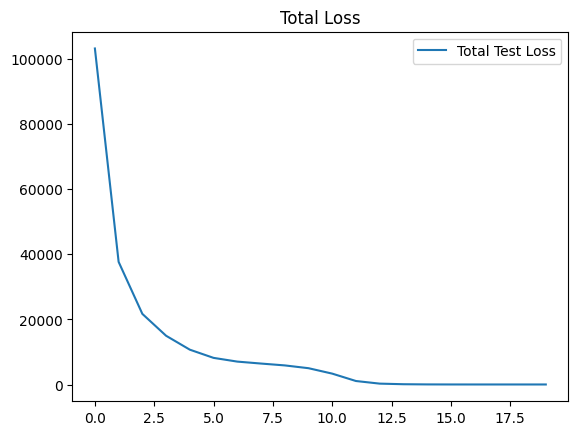

In [43]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [44]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 25.9442169946179


In [86]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[1][heavy_indices])

19

In [91]:
input_feature[1]

tensor([[ 9.9055e+02, -1.1981e+02, -1.9758e+02,  3.6450e+00,  1.2188e+01,
          2.3037e+01],
        [ 9.8946e+02, -1.1981e+02, -1.9734e+02,  5.7000e+00,  1.2150e+01,
          2.1233e+01],
        [ 9.8925e+02, -1.1953e+02, -1.9731e+02,  3.1425e+00,  9.8125e+00,
          2.4343e+01],
        [ 9.8855e+02, -1.1956e+02, -1.9715e+02,  1.8850e+00,  1.3818e+01,
          2.4630e+01],
        [ 9.8992e+02, -1.1983e+02, -1.9743e+02,  2.9675e+00,  1.1333e+01,
          2.0205e+01],
        [ 9.8943e+02, -1.1966e+02, -1.9726e+02,  3.9000e+00,  1.5405e+01,
          2.3155e+01],
        [ 9.9004e+02, -1.1987e+02, -1.9746e+02,  5.8950e+00,  1.5033e+01,
          2.1140e+01],
        [ 9.8771e+02, -1.1937e+02, -1.9695e+02,  1.1150e+00,  1.5480e+01,
          2.2572e+01],
        [ 9.8819e+02, -1.1946e+02, -1.9714e+02,  6.7750e-01,  9.3000e+00,
          2.3655e+01],
        [ 9.9071e+02, -1.1989e+02, -1.9760e+02,  2.0500e-01,  1.1910e+01,
          2.0628e+01],
        [ 9.8970e+02, -1.1981e

In [89]:
input_feature[20][heavy_indices]

tensor([[ 988.0892, -119.4267, -197.1811,    8.6700,   12.2650,    5.7800],
        [ 987.8766, -119.6128, -197.0914,    6.6625,   13.2975,    7.3550],
        [ 988.2318, -119.4606, -197.1266,   10.7600,   14.3675,    6.0725],
        [ 988.1378, -119.4080, -197.1591,    7.9000,   14.3075,    3.5900],
        [ 988.3259, -119.5440, -197.2413,   11.3925,   12.1150,    4.1550],
        [ 990.3723, -119.7142, -197.5180,    9.4425,   10.0075,    3.6175],
        [ 988.4277, -119.4336, -197.2217,    6.7875,   10.0650,    3.8775],
        [ 987.9294, -119.5494, -196.9796,   10.7875,    9.4625,    6.7325],
        [ 988.2319, -119.3948, -197.0307,    8.4475,    9.4275,    8.5725],
        [ 988.4231, -119.4822, -197.1822,    7.5850,   16.3625,    5.1025],
        [ 990.3566, -119.8965, -197.5355,    8.1750,   13.9775,    9.6950],
        [ 989.1078, -119.7592, -197.2795,    4.4675,   12.2575,    4.7175],
        [ 988.8674, -119.6386, -197.2975,   10.3000,   13.6575,    1.9750],
        [ 98

In [90]:
decoded_feature[20][heavy_indices]

tensor([[ 988.2982, -120.9526, -199.4407,   10.4116,   11.2550,   10.2175],
        [ 989.1937, -119.6050, -197.1925,   13.8708,   13.4954,   13.3435],
        [ 989.2074, -119.5789, -197.1488,   13.9773,   13.5552,   13.4336],
        [ 989.2237, -119.5480, -197.0972,   14.1033,   13.6259,   13.5401],
        [ 989.2014, -119.5903, -197.1680,   13.9306,   13.5290,   13.3940],
        [ 989.1762, -119.6381, -197.2478,   13.7360,   13.4198,   13.2294],
        [ 989.2096, -119.5747, -197.1418,   13.9943,   13.5648,   13.4480],
        [ 989.2238, -119.5478, -197.0968,   14.1040,   13.6263,   13.5407],
        [ 989.1929, -119.6063, -197.1947,   13.8653,   13.4924,   13.3388],
        [ 989.2234, -119.5486, -197.0982,   14.1007,   13.6244,   13.5379],
        [ 989.2237, -119.5480, -197.0972,   14.1032,   13.6259,   13.5401],
        [ 989.1823, -119.6266, -197.2286,   13.7828,   13.4461,   13.2691],
        [ 989.1700, -119.6499, -197.2677,   13.6875,   13.3926,   13.1885],
        [ 98

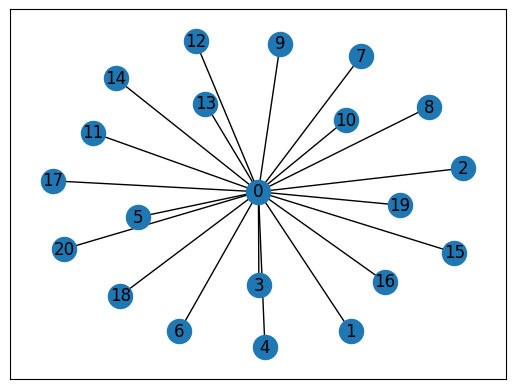

In [48]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

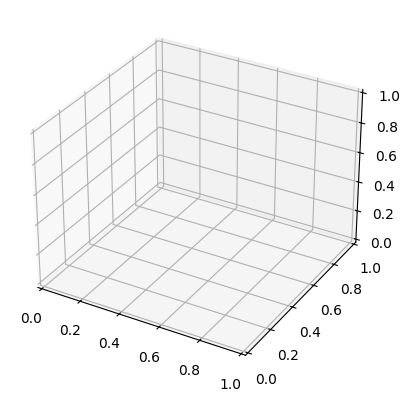

In [50]:
fig=plt.figure()
ax=plt.axes(projection='3d')    
ax.scatter3D(input_feature[0][heavy_indices][:,0],input_feature[0][heavy_indices][:,1],input_feature[0][heavy_indices][:,2],c=input_feature[0][heavy_indices][:,0],cmap='Greens')